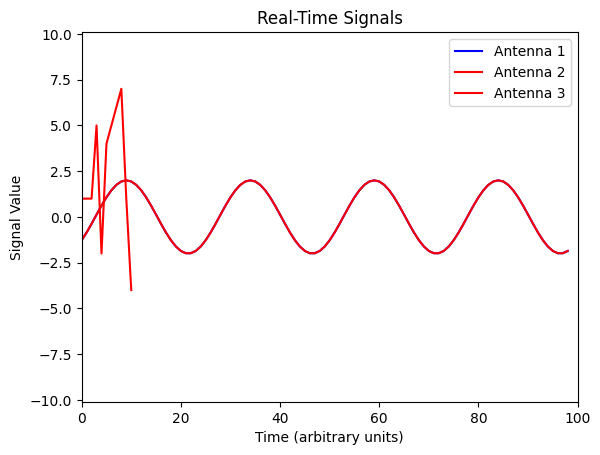

In [ ]:
import asyncio
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, GCRS
from astropy import units as u
from astropy.time import Time
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict


axes = None
fig = None

start_time = datetime(2025, 2, 21, 12, 0, 0)
current_time = start_time

# Let's start with simple example 
# we have a baseline in xyz coordinates
vla = EarthLocation.of_site('vla')
source_ra = 10*u.hourangle
source_dec = -30*u.deg
source = SkyCoord(ra=source_ra, dec=source_dec, frame='icrs')


antenna_1_pos = np.array([0,0,0])
antenna_2_pos = np.array([400,200,10])

obs_wavelength = 0.001


# convert to x,y,z coordinates where z points to the NCP
# we need the latitude of the site
# y will point locally eastward
# z aligns with NCP
# think of projection of NU axes onto z.
# x is y X z
latitude = vla.lat
transform_enu_xyz = np.array([
    [0, -np.sin(latitude), np.cos(latitude)], 
    [1, 0, 0], 
    [0, np.cos(latitude), np.sin(latitude)]
])



class Signal:

    all_signals = []
    

    def __init__(self, frequency: float, amplitude: float, phase_shift: float, source_ra: float, source_dec: float):
        self.frequency = frequency
        self.amplitude = amplitude
        self.phase_shift = phase_shift
        self.source_ra = source_ra
        self.source_dec = source_dec

        Signal.all_signals.append(self)

    def get_signal_value(self, time: float) -> float:
        signal = self.amplitude * math.cos(2 * math.pi * self.frequency * time + self.phase_shift)
        return signal

    @classmethod
    def get_all_instances(cls):
        return cls.all_signals


    
class Antenna:

    all_antennae = []

    color_map = {
        1: 'b',
        2: 'r',
        3: 'g',
        4: 'p',
    }
    
    def __init__(self, antenna_id: int, baseline_enu: np.array):
        self.id = antenna_id
        self.baseline_enu = baseline_enu
        self.baseline_xyz = np.matmul(transform_enu_xyz, baseline_enu)
        Antenna.all_antennae.append(self)
    
    def get_signal_delay(self, transform_xyz_uvw, obs_wavelength) -> float:
        baseline_uvw = np.matmul(transform_xyz_uvw, self.baseline_xyz) / obs_wavelength
        angle_degrees = np.arccos(baseline_uvw[2] / np.linalg.norm(baseline_uvw)) * 360 / (2 * np.pi)
        delay_distance = baseline_uvw[2]
        # geometric delay. delay_distance is in wavelengths so use baseline_uvw[2] * lambda (wavelength in m) / c 
        # to get delay time
        Tg = delay_distance * obs_wavelength / (3.00 * 10 ** 8)
        return Tg

    @classmethod
    def get_all_instances(cls):
        return cls.all_antennae

antennae = [
    Antenna(1, np.array([0,0,0])),
    Antenna(2, np.array([4000, 200, 10])),
]
signals = [
    Signal(1, 1, 0, source_ra, source_dec),
    Signal(1, 1, np.pi, source_ra, source_dec + 5 * u.deg),
    Signal(4, 2, 0, source_ra, source_dec + 10 * u.deg),
]


received_signals = defaultdict(list)

async def telescope_signal_receivers():
    print("Starting telescope signal receiving")
    time = 0

    
    print("done initialization")
    while True:
        all_antennae = Antenna.get_all_instances()
        all_signals = Signal.get_all_instances()

        
        obs_time = Time(current_time.isoformat(), location=vla)

        obs_local_sidereal_time = obs_time.sidereal_time(kind='mean')

        
        for antenna in all_antennae:
            signal_combined = 0
            for signal in all_signals:
                
                hour_angle = obs_local_sidereal_time - signal.source_ra 
                
                transform_xyz_uvw = np.array([
                    [np.sin(hour_angle), np.cos(hour_angle), 0],
                    [-np.sin(signal.source_dec) * np.cos(hour_angle), np.sin(signal.source_dec) * np.sin(hour_angle), np.cos(signal.source_dec)],
                    [np.cos(hour_angle) * np.cos(signal.source_dec), np.sin(hour_angle) * np.cos(signal.source_dec), np.sin(signal.source_dec)]    
                ])
                
                # replace obs_wavelength with signal.wavelength?
                antenna_delay = antenna.get_signal_delay(transform_xyz_uvw, obs_wavelength)
                signal_combined += signal.get_signal_value(time - antenna_delay)
            received_signals[antenna.id].append(signal_combined)
            if len(received_signals[antenna.id]) >= 100:
                received_signals[antenna.id].pop(0)

        time += 0.01
        await asyncio.sleep(0.01)
    

def update_plot():
    clear_output(wait=True)
    for antenna in Antenna.get_all_instances():
        plt.plot(received_signals[antenna.id], label=f"Antenna {antenna.id}", color=Antenna.color_map[antenna.id])
    plt.title("Real-Time Signals")
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Signal Value")
    plt.xlim(0, 100) 
    plt.ylim(-10.1, 10.1)

    plt.legend()
    plt.show() 
    plt.pause(0.001)




async def handle_signal_plot():
    
    while True:
        update_plot()
        await asyncio.sleep(.001)


async def main():
    print("starting main loop")
    await asyncio.gather(
        telescope_signal_receivers(),
        handle_signal_plot()
    )


await main()

In [6]:
received_signals[1][:10]

[-1.6180339887498947,
 -1.8595529717765025,
 -1.9842294026289558,
 -1.984229402628956,
 -1.859552971776503,
 -1.618033988749895,
 -1.2748479794973795,
 -0.8515585831301444,
 -0.3747626291714496,
 0.1255810390586275]

In [7]:
received_signals[2][:10]

[-1.6178655259804986,
 -1.8594479614126889,
 -1.9841945132654988,
 -1.9842669021056945,
 -1.8596605843832128,
 -1.6182050378997581,
 -1.2750718069055997,
 -0.8518212181605103,
 -0.37504766629471675,
 0.1252914098269981]